In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier

# Load the dataset
df = pd.read_csv("predictive_maintenance.csv")

# Define features and target variable
X = df.iloc[:, 2:8]
y = df.iloc[:, -1]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode the 'Type' feature
oe = OrdinalEncoder(categories=[['L', 'M', 'H']])
X_train['Type'] = oe.fit_transform(X_train[['Type']]).astype(int)
X_test['Type'] = oe.transform(X_test[['Type']]).astype(int)

# Define the target categories and encode the target variable
categories = ['No Failure', 'Heat Dissipation Failure', 'Power Failure', 'Overstrain Failure', 'Tool Wear Failure', 'Random Failures']
custom_encoder = {cat: i for i, cat in enumerate(categories)}
y_train_encoded = y_train.map(custom_encoder)
y_test_encoded = y_test.map(custom_encoder)

# Initialize the LabelEncoder
le = LabelEncoder()
le.fit(range(len(categories)))  # Fit on the range of expected categories
y_train = le.transform(y_train_encoded)  # Transform the encoded training labels
y_test = le.transform(y_test_encoded)  # Transform the encoded testing labels

In [3]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Initialize and fit the SVC model
svc = SVC()
svc.fit(X_train, y_train)

# Predict on the test set
y_pred_svc = svc.predict(X_test)

# Calculate accuracy
svc_train = round(svc.score(X_train, y_train) * 100, 2)
svc_accuracy = round(accuracy_score(y_test, y_pred_svc) * 100, 2)

# Print accuracy results
print("Training Accuracy    :", svc_train, "%")
print("Model Accuracy Score :", svc_accuracy, "%")
print("\033[1m--------------------------------------------------------\033[0m")

# Print classification report with zero_division parameter
print("Classification Report: \n", classification_report(y_test, y_pred_svc, zero_division=0))
print("\033[1m--------------------------------------------------------\033[0m")


Training Accuracy    : 96.58 %
Model Accuracy Score : 96.85 %
--------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1935
           1       0.00      0.00      0.00        15
           2       0.75      0.15      0.25        20
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00         6

    accuracy                           0.97      2000
   macro avg       0.29      0.19      0.21      2000
weighted avg       0.94      0.97      0.95      2000

--------------------------------------------------------


In [4]:
clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=6, n_estimators=100)
X_train.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '').replace(' ', '_') for col in X_train.columns]
X_test.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '').replace(' ', '_') for col in X_test.columns]
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
xgb_train = round(clf.score(X_train, y_train) * 100, 2)
xgb_accuracy = round(accuracy_score(y_pred, y_test) * 100, 2)

print("Training Accuracy    :", xgb_train, "%")
print("Model Accuracy Score :", xgb_accuracy, "%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n", classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")


Training Accuracy    : 100.0 %
Model Accuracy Score : 98.25 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1935
           1       0.88      0.93      0.90        15
           2       0.80      0.60      0.69        20
           3       0.77      0.77      0.77        13
           4       0.25      0.09      0.13        11
           5       0.00      0.00      0.00         6

    accuracy                           0.98      2000
   macro avg       0.61      0.56      0.58      2000
weighted avg       0.98      0.98      0.98      2000

--------------------------------------------------------


In [5]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Plots the learning curve for a given model.

    Parameters:
    - model: the machine learning model to evaluate
    - X: feature dataset
    - y: target variable
    - cv: number of cross-validation folds
    - n_jobs: number of jobs to run in parallel
    - train_sizes: relative or absolute number of training examples to use for generating the learning curve

    Returns:
    - None
    """
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, cv=cv, n_jobs=n_jobs, scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.title('Learning Curve')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Usage example
# plot_learning_curve(clf, X_train, y_train)


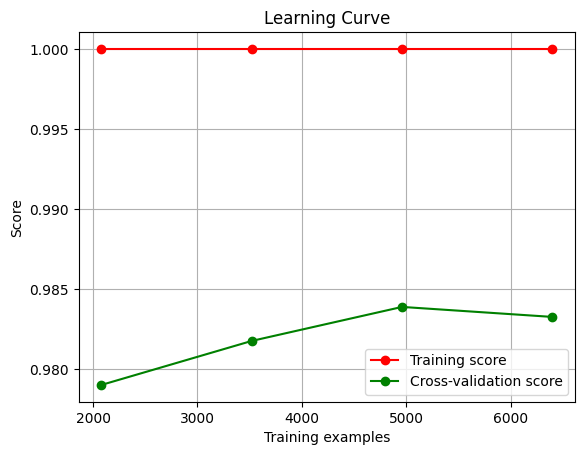

In [6]:
plot_learning_curve(clf,X_train, y_train, cv=5)

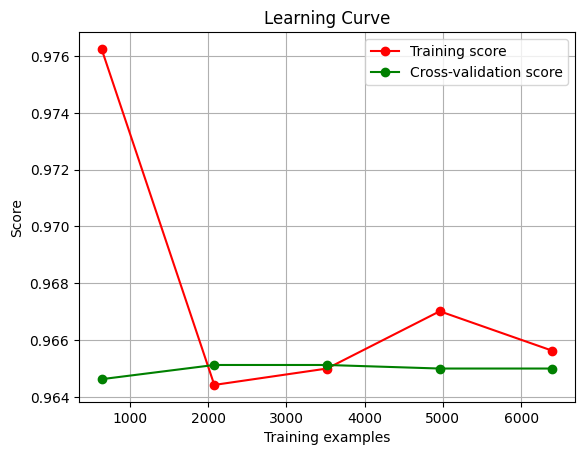

In [7]:
plot_learning_curve(svc,X_train, y_train, cv=5)


In [8]:
import pickle
import joblib

# Assuming you have 'svc' as your trained model
pickle.dump(svc,open('model_svc.pkl','wb'))
joblib.dump(svc, 'model_svc.joblib')

# Assuming you have 'clf' as your trained model
pickle.dump(clf,open('model_xgboost.pkl','wb'))
joblib.dump(clf, 'model_xgboost.joblib')

['model_xgboost.joblib']